This notebook uses the data produced by `0_fever_decode_wikipage_IDs_to_sentences` to train and evaluate a BERT model for textual entailment.

It uses the claim, the labels, and the *first sentence only* of the datasets generated in the mentioned notebook.

This is a **bad approach**, and we latter choose to follow a much better one.
However, I still need to document this in order to understand what I did 1y ago and why.

This version trains for 3 classes (Supports, Refutes, and Not Enough Info).

In [1]:
import numpy as np
import torch
from pandas import read_csv
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

from seaborn import displot, boxplot
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [2]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'bert-base-uncased' # We could use bert-large with the new GPU from gravity. Would it perform better?
# It probably would be better to check after the whole pipeline is tested. Also it probably should not be uncased, so let's
# test that too!
BATCH_SIZE = 16
NUM_WORKERS = 2 # On gravity, we were told to use 2 workers. Perhaps because we have 2 GPUs?
DEVICE

'cuda:0'

In [3]:
df_train = read_csv('./data/support_data_v1/train_wikidecoded.csv', encoding='UTF-8')
df_dev = read_csv('./data/support_data_v1/shared_task_dev_wikidecoded.csv', encoding='UTF-8')
df_test = read_csv('./data/support_data_v1/shared_task_test_wikidecoded.csv', encoding='UTF-8')

columns_to_keep = ['claim','first_sentence','label_numeric']
df_train = df_train[columns_to_keep]
df_dev = df_dev[columns_to_keep]

df_test, df_dev = train_test_split(df_dev, test_size=.5)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_dev = df_dev.reset_index(drop=True)
df_train.shape, df_test.shape, df_dev.shape

((145449, 3), (9999, 3), (9999, 3))

In [4]:
df_train.label_numeric.value_counts()

0    80035
2    35639
1    29775
Name: label_numeric, dtype: int64

In [5]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, fast=True)
# standard Bert tokenizer. don't know why we make it fast.

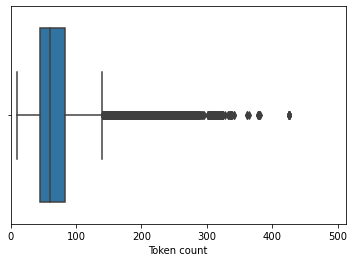

In [6]:
check_lengths = True

if check_lengths:
    # This helps see what a good max length would be
    def get_tokenized_len(row):
        tokens = tokenizer.encode(row['claim'], row['first_sentence'], max_length=512, truncation='only_second')
        return len(tokens)

    for df in [df_train, df_test, df_dev]:
        df['tokenized_len'] = df.apply(get_tokenized_len, axis=1)

    tokenized_lens = df_train['tokenized_len'].tolist() +\
        df_test['tokenized_len'].tolist() +\
        df_dev['tokenized_len'].tolist()

    boxplot(x=tokenized_lens)
    plt.xlim([0, 512]);
    plt.xlabel('Token count');

    #print(np.max(tokenized_lens))
    
MAX_LEN = 400 #This means a few cases get cut down. I don't think they're many, but also don't think there
# is a big drop in performance if we let them be? I would compare performance with MAX_LEN=425 and see.

In [7]:
# So here we reate dataset and dataloader instances for the FEVER data from the bad approach
# torch.utils.data.Dataset and torch.utils.data.DataLoader were used
# information about them can be found here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class FEVERDataset(Dataset):
    def __init__(self, claims, sentences, labels, tokenizer, max_len):
        self.claims=claims
        self.sentences=sentences
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_len=max_len
        
    def __len__(self):
        return(len(self.claims))
    
    def __getitem__(self, idx):
        claim = self.claims[idx]
        sentence = self.sentences[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            claim,
            sentence,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        ).to(DEVICE)
        
        return {
            'claim': claim,
            'sentence': sentence,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long).to(DEVICE)
        }
    
def to_data_loader(df, tokenizer, max_len, batch_size, num_workers):
    dataset = FEVERDataset(
        claims = df.claim,
        sentences = df.first_sentence,
        labels = df.label_numeric,
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return dataset, DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    
train_dataset, train_dataloader = to_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE, NUM_WORKERS)
test_dataset, test_dataloader = to_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE, NUM_WORKERS)
dev_dataset, dev_dataloader = to_data_loader(df_dev, tokenizer, MAX_LEN, BATCH_SIZE, NUM_WORKERS)

In [8]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [33]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [34]:
!nvidia-smi

Thu Feb 10 16:19:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3070    On   | 00000000:5E:00.0 Off |                  N/A |
| 30%   32C    P2    45W / 220W |   2282MiB /  7982MiB |     67%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3070    On   | 00000000:AF:00.0 Off |                  N/A |
| 30%   

In [35]:
training_args = TrainingArguments(
    output_dir='./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/',
    num_train_epochs=3,
    evaluation_strategy="steps",     # Evaluation is done at the end of each epoch.
    per_device_train_batch_size=4,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    eval_steps=500,
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints. 
    dataloader_pin_memory=False,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = 3).to(DEVICE)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics      # metrics to be computed
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/k20036346/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.692000,0.501508,0.803080,0.802941,0.814252,0.804908
1000,0.427700,0.386455,0.856586,0.853852,0.874237,0.858769
1500,0.365500,0.650821,0.844284,0.838938,0.872901,0.846848
2000,0.356100,0.397619,0.873087,0.872698,0.887917,0.874820
2500,0.327900,0.548474,0.865487,0.865532,0.889112,0.867252
3000,0.312300,0.411730,0.888089,0.888200,0.897131,0.889524
3500,0.326300,0.518736,0.872987,0.873991,0.883339,0.874142
4000,0.338200,0.390755,0.896590,0.897077,0.902238,0.897763
4500,0.300900,0.342317,0.897490,0.897105,0.903501,0.898847
5000,0.299700,0.429417,0.894589,0.893821,0.906036,0.896218


***** Running Evaluation *****
  Num examples = 9999
  Batch size = 128
Saving model checkpoint to ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-500
Configuration saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-500/config.json
Model weights saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-500/pytorch_model.bin
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 9999
  Batch size = 128
Saving model checkpoint to ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-1000
Configuration saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-1000/config.json
Model weights saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_

Saving model checkpoint to ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-5500
Configuration saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-5500/config.json
Model weights saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-5500/pytorch_model.bin
Deleting older checkpoint [run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-4500] due to args.save_total_limit
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 9999
  Batch size = 128
Saving model checkpoint to ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-6000
Configuration saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-6000/config.json
Model weigh

***** Running Evaluation *****
  Num examples = 9999
  Batch size = 128
Saving model checkpoint to ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-10500
Configuration saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-10500/config.json
Model weights saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-10500/pytorch_model.bin
Deleting older checkpoint [run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-8000] due to args.save_total_limit
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 9999
  Batch size = 128
Saving model checkpoint to ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-11000
Configuration saved in ./run/1_Using_

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
***** Running Evaluation *****
  Num examples = 9999
  Batch size = 128
Saving model checkpoint to ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-15000
Configuration saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-15000/config.json
Model weights saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-15000/pytorch_model.bin
Deleting older checkpoint [run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-14500] due to args.save_total_limit
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along 

  Num examples = 9999
  Batch size = 128
Saving model checkpoint to ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-19000
Configuration saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-19000/config.json
Model weights saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-19000/pytorch_model.bin
Deleting older checkpoint [run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-18500] due to args.save_total_limit
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
***** Ru

Configuration saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-23500/config.json
Model weights saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-23500/pytorch_model.bin
Deleting older checkpoint [run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-22500] due to args.save_total_limit
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
***** Running Evaluation *****
  Num examples = 9999
  Batch size = 128
Saving model checkpoint to ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Cl

***** Running Evaluation *****
  Num examples = 9999
  Batch size = 128
Saving model checkpoint to ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-28500
Configuration saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-28500/config.json
Model weights saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-28500/pytorch_model.bin
Deleting older checkpoint [run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-27500] due to args.save_total_limit
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 9999
  Batch size = 128
Saving model checkpoint to ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-29000
Configuration saved in ./run/1_Using

Deleting older checkpoint [run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-32500] due to args.save_total_limit
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 9999
  Batch size = 128
Saving model checkpoint to ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-33500
Configuration saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-33500/config.json
Model weights saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-33500/pytorch_model.bin
Deleting older checkpoint [run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-33000] due to args.save_total_limit
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_

Model weights saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-37500/pytorch_model.bin
Deleting older checkpoint [run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-36000] due to args.save_total_limit
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
***** Running Evaluation *****
  Num examples = 9999
  Batch size = 128
Saving model checkpoint to ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-38000
Configuration saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkp

***** Running Evaluation *****
  Num examples = 9999
  Batch size = 128
Saving model checkpoint to ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-42500
Configuration saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-42500/config.json
Model weights saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-42500/pytorch_model.bin
Deleting older checkpoint [run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-42000] due to args.save_total_limit
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tok

***** Running Evaluation *****
  Num examples = 9999
  Batch size = 128
Saving model checkpoint to ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-47000
Configuration saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-47000/config.json
Model weights saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-47000/pytorch_model.bin
Deleting older checkpoint [run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-46500] due to args.save_total_limit
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 9999
  Batch size = 128
Saving model checkpoint to ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-47500
Configuration saved in ./run/1_Using

Configuration saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-52500/config.json
Model weights saved in ./run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-52500/pytorch_model.bin
Deleting older checkpoint [run/1_Using_BERT_on_FEVER_with_Trainer_3_Classes/checkpoint-52000] due to args.save_total_limit
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy.

In [36]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 9999
  Batch size = 128


{'eval_loss': 0.33259961009025574,
 'eval_accuracy': 0.9267926792679267,
 'eval_f1': 0.9269455882667527,
 'eval_precision': 0.9294430387865695,
 'eval_recall': 0.927704976442684,
 'eval_runtime': 56.0145,
 'eval_samples_per_second': 178.507,
 'eval_steps_per_second': 1.41,
 'epoch': 3.0}

In [37]:
trainer.evaluate(eval_dataset = test_dataset, metric_key_prefix='test')

***** Running Evaluation *****
  Num examples = 9999
  Batch size = 128
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.34793147444725037,
 'test_accuracy': 0.9241924192419242,
 'test_f1': 0.9230951471045626,
 'test_precision': 0.9274719589553491,
 'test_recall': 0.923149206033825,
 'test_runtime': 55.2431,
 'test_samples_per_second': 181.0,
 'test_steps_per_second': 1.43,
 'epoch': 3.0}

In [38]:
trainer.evaluate(eval_dataset = train_dataset, metric_key_prefix='train')

***** Running Evaluation *****
  Num examples = 145449
  Batch size = 128
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always b

{'train_loss': 0.12888619303703308,
 'train_accuracy': 0.9717289221651575,
 'train_f1': 0.9680513738977207,
 'train_precision': 0.9708277261298428,
 'train_recall': 0.9654084634178749,
 'train_runtime': 819.2869,
 'train_samples_per_second': 177.531,
 'train_steps_per_second': 1.388,
 'epoch': 3.0}

In [39]:
model.save_pretrained('models/BERT_FEVER_v1_model')
tokenizer.save_pretrained('models/BERT_FEVER_v1_tok')

Configuration saved in models/BERT_FEVER_v1_model/config.json
Model weights saved in models/BERT_FEVER_v1_model/pytorch_model.bin
tokenizer config file saved in models/BERT_FEVER_v1_tok/tokenizer_config.json
Special tokens file saved in models/BERT_FEVER_v1_tok/special_tokens_map.json


('models/BERT_FEVER_v1_tok/tokenizer_config.json',
 'models/BERT_FEVER_v1_tok/special_tokens_map.json',
 'models/BERT_FEVER_v1_tok/vocab.txt',
 'models/BERT_FEVER_v1_tok/added_tokens.json')

In [50]:
classes = ['supports','refutes','not enough info']

claims = [
    'Barack Obama was part of the 109th United States Congress.',
    'France is a member of the European Air Transport Command.',
    'The Moon\'s diocese is the Roman Catholic Diocese of Arizona.',
    'Toyota is a member of the Linux Foundation.'
]

sentences = [
    'OBAMA, Barack, a Senator from Illinois and 44th President of the United States;',
    'The driving parties were France and Germany, who looked back at a strong bilateral cooperation in the field of air transport.',
    'It might sound strange, but in addition to encompassing nine counties and hundreds of cities, the Diocese of Orlando, Florida also has jurisdiction over an otherworldly object: the Moon.',
    'Carmakers are using new technologies to deliver on consumer expectations for the same connectivity in their cars as they’ve come to expect in their homes and offices.'
]

def get_predictions(claims, sentences, soft=False):
    enc = tokenizer(claims,sentences,max_length=MAX_LEN,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_tensors='pt',).to(DEVICE)

    # evaluate model:
    model.eval()

    with torch.no_grad():
        out = model(input_ids=enc['input_ids'], attention_mask=enc['attention_mask'])
        predicted_classes = [classes[i] for i in np.argmax(torch.softmax(out.logits,dim=1).tolist(), axis=1)]
        return predicted_classes, torch.softmax(out.logits,dim=1).tolist() if soft else out.logits

print(get_predictions(claims, sentences))

(['supports', 'supports', 'refutes', 'not enough info'], tensor([[ 2.7282,  0.4924, -3.5203],
        [ 4.1599, -0.6437, -5.0936],
        [-0.6981,  4.9072, -3.9848],
        [-2.9713, -2.3553,  6.7513]], device='cuda:0'))


In [84]:
import en_core_web_sm
nlp = en_core_web_sm.load()

claims = [
    'The Linux Foundation is a nonprofit organization.',
    'The Linux Foundation is not a nonprofit organization.',
    'Toyota is a member of the Linux Foundation.',
    'Toyota is not a member of the Linux Foundation.',
    'Paris is a city in France.',
    'Toyota is the owner of Denso.',
    'Jim Zemlin is the executive director of the Linux Foundation.'
]
# text from https://www.linuxfoundation.org/press-release/2011/07/toyota-joins-linux-foundation/
test_text = '''
    Toyota looks towards open innovation and collaboration to help transform auto industry

    SAN FRANCISCO, July 5, 2011 – The Linux Foundation, the nonprofit organization dedicated to accelerating the growth of Linux, today announced that Toyota is its newest member.

    A major shift is underway in the automotive industry. Carmakers are using new technologies to deliver on consumer expectations for the same connectivity in their cars as they’ve come to expect in their homes and offices. From dashboard computing to In-Vehicle-Infotainment (IVI), automobiles are becoming the latest wireless devices – on wheels.

    The Linux operating system is providing a common platform that helps connect the world’s network of devices, including cars. As an open source operating system, it provides automakers and their partners the flexibility they require to bring to market the latest technology features quickly.

    Toyota is joining The Linux Foundation as a Gold member to maximize its own investment in Linux while fostering open innovation throughout the automotive ecosystem.

    “Linux gives us the flexibility and technology maturity we require to evolve our In-Vehicle-Infotainment and communications systems to address the expectations of our customers,” said Kenichi Murata, Project General Manager, Electronics Development Div. 1, TOYOTA MOTOR CORPORATION. “The Linux Foundation provides us with a neutral forum in which we can collaborate with the world’s leading technology companies on open innovation that accelerates that evolution.”

    “We are very pleased to welcome Toyota to The Linux Foundation. The company’s leadership and proven innovation will bring important contributions to the advancement of Linux,” said Jim Zemlin, executive director at The Linux Foundation. ‘Toyota’s investment in Linux is a testament to the ubiquity of the operating system and its ability to support the latest market requirements.”

    About The Linux Foundation
    The Linux Foundation is a nonprofit consortium dedicated to fostering the growth of Linux. Founded in 2000, the organization sponsors the work of Linux creator Linus Torvalds and promotes, protects and advances the Linux operating system by marshaling the resources of its members and the open source development community. The Linux Foundation provides a neutral forum for collaboration and education by hosting Linux conferences, including LinuxCon, and generating original Linux research and content that advances the understanding of the Linux platform. Its web properties, including Linux.com, reach approximately two million people per month and include important Linux video resources. The organization also provides extensive Linux training opportunities that feature the Linux kernel community’s leading experts as instructors. Follow The Linux Foundation on Twitter.

    ###

    Trademarks: The Linux Foundation, Linux Standard Base, MeeGo and Yocto Project are trademarks of The Linux Foundation. Linux is a trademark of Linus Torvalds.
'''
for claim in claims[:]:
    print(claim)
    sents = [s.text.strip() for s in list(nlp(test_text).sents)]
    cls, outputs = get_predictions([claim]*len(sents), sents, soft=False)
    #for s,c,o in list(zip(sents,cls,outputs)):
    #    print(s)
    #    print(c.upper())
    #    print(o)
    #    print('--------------------------------------\n')
    print('Total:',end=' ')
    sum_scores = torch.sum(torch.softmax(outputs,dim=1), dim=0).tolist()
    print(classes[np.argmax(sum_scores)].upper(), sum_scores)
    print()

The Linux Foundation is a nonprofit organization.
Total: SUPPORTS [10.779036521911621, 1.6979856491088867, 7.522977828979492]

The Linux Foundation is not a nonprofit organization.
Total: REFUTES [1.2677773237228394, 13.65703010559082, 5.075192451477051]

Toyota is a member of the Linux Foundation.
Total: SUPPORTS [14.690399169921875, 0.13435021042823792, 5.175251007080078]

Toyota is not a member of the Linux Foundation.
Total: REFUTES [1.0204172134399414, 14.97512149810791, 4.00446081161499]

Paris is a city in France.
Total: NOT ENOUGH INFO [0.0005974351661279798, 0.0011609744979068637, 19.998241424560547]

Toyota is the owner of Denso.
Total: NOT ENOUGH INFO [0.8975404500961304, 3.3360962867736816, 15.766363143920898]

Jim Zemlin is the executive director of the Linux Foundation.
Total: NOT ENOUGH INFO [5.486236572265625, 1.6466472148895264, 12.867116928100586]



## Loading the model again for sanity checking

In [85]:
model2 = BertForSequenceClassification.from_pretrained('models/BERT_FEVER_v1_model')
tokenizer2 = BertTokenizer.from_pretrained('models/BERT_FEVER_v1_tok')

loading configuration file models/BERT_FEVER_v1_model/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file models/

In [86]:
trainer2 = Trainer(
    model=model2,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics      # metrics to be computed
)

trainer2.evaluate(eval_dataset = test_dataset, metric_key_prefix='test')

***** Running Evaluation *****
  Num examples = 9999
  Batch size = 128
/home/k20036346/.conda/envs/cuda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'test_loss': 0.34793147444725037,
 'test_accuracy': 0.9241924192419242,
 'test_f1': 0.9230951471045626,
 'test_precision': 0.9274719589553491,
 'test_recall': 0.923149206033825,
 'test_runtime': 55.1801,
 'test_samples_per_second': 181.207,
 'test_steps_per_second': 1.432}

In [89]:
classes = ['supports','refutes','not enough info']
claim = 'John was born in December.'
sentence = 'John had lunch in December of 1992 with his dad.'
enc = tokenizer2(claim,sentence,max_length=MAX_LEN,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_tensors='pt',).to(DEVICE)

# evaluate model:
model2.eval()

with torch.no_grad():
    out = model2(input_ids=enc['input_ids'], attention_mask=enc['attention_mask'])
    print(classes[np.argmax(torch.softmax(out.logits,dim=1).tolist(), axis=1)[0]])
    print(out)



supports
SequenceClassifierOutput(loss=None, logits=tensor([[ 4.1762, -0.6568, -5.1233]], device='cuda:0'), hidden_states=None, attentions=None)


model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. You need to turn off them during model evaluation, and .eval() will do it for you. In addition, the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation:

```
# evaluate model:
model.eval()

with torch.no_grad():
    ...
    out_data = model(data)
    ...
```

BUT, don't forget to turn back to training mode after eval step:

```
# training step
...
model.train()
...
```